# 2.5: Advanced Geospatial Plotting 

## Imports & Settings

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime as dt
import seaborn as sns
from keplergl import KeplerGl
import json

In [6]:
data = pd.read_parquet("2022_Citibike_Dataset.parquet", engine = "pyarrow")

In [7]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source,avgTempCelsius
0,BFD29218AB271154,electric_bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802117,-73.968181,40.804038,-73.945925,member,202201-citibike-tripdata_1,-6.0
1,7C953F2FD7BE1302,classic_bike,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,4 Ave & 3 St,4028.04,Boerum Pl\t& Pacific St,4488.09,40.673746,-73.985649,40.688489,-73.991160,member,202201-citibike-tripdata_1,1.6
2,95893ABD40CED4B8,electric_bike,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,1 Ave & E 62 St,6753.08,5 Ave & E 29 St,6248.06,40.761227,-73.960940,40.745168,-73.986831,member,202201-citibike-tripdata_1,-2.3
3,F853B50772137378,classic_bike,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2 Ave & E 96 St,7338.02,5 Ave & E 29 St,6248.06,40.783964,-73.947167,40.745168,-73.986831,member,202201-citibike-tripdata_1,1.4
4,7590ADF834797B4B,classic_bike,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,6 Ave & W 34 St,6364.10,5 Ave & E 29 St,6248.06,40.749640,-73.988050,40.745168,-73.986831,member,202201-citibike-tripdata_1,-5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838801,1F223EDAFF420AE3,electric_bike,2022-12-01 20:26:45.847,2022-12-01 20:30:46.012,Avenue D & E 3 St,5436.09,Stanton St & Chrystie St,5523.02,40.720701,-73.977939,40.722293,-73.991475,member,202212-citibike-tripdata_2,5.7
29838802,CFA5C560ACB73B8E,classic_bike,2022-12-26 13:46:34.237,2022-12-26 13:52:43.900,43 Ave & 47 St,6209.05,39 Ave & 45 St,6401.03,40.744806,-73.917290,40.749478,-73.918265,member,202212-citibike-tripdata_2,-4.7
29838803,11C8C5E0DB947B07,classic_bike,2022-12-01 05:56:14.903,2022-12-01 06:06:10.357,Avenue D & E 3 St,5436.09,Bleecker St & Crosby St,5679.08,40.720828,-73.977932,40.726156,-73.995102,member,202212-citibike-tripdata_2,5.7
29838804,5B9B083C534A5964,classic_bike,2022-12-02 11:54:15.871,2022-12-02 12:01:00.747,Montague St & Clinton St,4677.06,Sands St & Jay St,4821.03,40.694271,-73.992327,40.700119,-73.986200,member,202212-citibike-tripdata_2,3.4


## Create df of stations and coordinates

In [9]:
# filter out rows where either start_station_name or end_station_name are empty, (n = 70k)
filtered_data = data[data['start_station_name'].notna() & data['end_station_name'].notna()] 

In [10]:
# create df of all unique stations and then average the lat/long coordinates per station
coords_df = \
(pd.concat([ 
    filtered_data[["start_station_name", "start_lat", "start_lng"]].rename(columns = lambda x: x.replace("start_", "")),
    filtered_data[["end_station_name", "end_lat", "end_lng"]].rename(columns = lambda x: x.replace("end_", ""))
    ], ignore_index = True) # stack both start and end stations to get all unique
 .drop_duplicates()
 .groupby(['station_name'], as_index = False)
 .agg({'lat': 'mean',
       'lng': 'mean'})
)

coords_df

,station_name,lat,lng
0,1 Ave & E 110 St,40.792362,-73.938196
1,1 Ave & E 16 St,40.732256,-73.981639
2,1 Ave & E 18 St,40.734081,-73.980427
3,1 Ave & E 30 St,40.741519,-73.975316
4,1 Ave & E 39 St,40.747330,-73.971051
...,...,...,...
1837,Wyckoff St & 3 Ave,40.682813,-73.982668
1838,Wyckoff St & Nevins St,40.683382,-73.984180
1839,Wythe Ave & Metropolitan Ave,40.716971,-73.963148
1840,Yankee Ferry Terminal,40.687112,-74.016628


In [11]:
# create df with unique start/end and count number of trips, then merge coords_df to both start and end stations
df = (filtered_data \
      .loc[:,["start_station_name", "end_station_name"]]
      .groupby(["start_station_name", "end_station_name"], as_index = False).size()
      .rename(columns = {"size": "count"})
      .merge(coords_df.rename(columns = lambda x: f"start_{x}"))
      .merge(coords_df.rename(columns = lambda x: f"end_{x}"))
)

df

,start_station_name,end_station_name,count,start_lat,start_lng,end_lat,end_lng
0,1 Ave & E 110 St,1 Ave & E 110 St,791,40.792362,-73.938196,40.792362,-73.938196
1,1 Ave & E 16 St,1 Ave & E 110 St,5,40.732256,-73.981639,40.792362,-73.938196
2,1 Ave & E 18 St,1 Ave & E 110 St,6,40.734081,-73.980427,40.792362,-73.938196
3,1 Ave & E 30 St,1 Ave & E 110 St,25,40.741519,-73.975316,40.792362,-73.938196
4,1 Ave & E 39 St,1 Ave & E 110 St,78,40.747330,-73.971051,40.792362,-73.938196
...,...,...,...,...,...,...,...
1013417,W 34 St & 11 Ave,6 St & Grand St,1,40.756108,-74.002291,40.744398,-74.034501
1013418,W 37 St & 10 Ave,6 St & Grand St,1,40.756587,-73.998079,40.744398,-74.034501
1013419,W 34 St & 11 Ave,Hoboken Ave at Monmouth St,1,40.756108,-74.002291,40.735208,-74.046964
1013420,W 35 St & Dyer Ave,Clinton St & 7 St,1,40.754797,-73.997634,40.745420,-74.033320


In [12]:
cumsum_df = (df\
           .sort_values(by = "count", ascending = False)
           .reset_index(drop = True)
           .assign(
               cumulative_count = lambda df: df["count"].cumsum(),
               cumulative_percent = lambda df: df["count"].cumsum() / df["count"].sum())
          )

cumsum_df

,start_station_name,end_station_name,count,start_lat,start_lng,end_lat,end_lng,cumulative_count,cumulative_percent
0,Central Park S & 6 Ave,Central Park S & 6 Ave,12041,40.765965,-73.976420,40.765965,-73.976420,12041,0.000404
1,7 Ave & Central Park South,7 Ave & Central Park South,8541,40.766622,-73.979305,40.766622,-73.979305,20582,0.000691
2,Roosevelt Island Tramway,Roosevelt Island Tramway,8213,40.757230,-73.953537,40.757230,-73.953537,28795,0.000967
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7287,40.764334,-73.973853,40.764334,-73.973853,36082,0.001212
4,Soissons Landing,Soissons Landing,7275,40.692462,-74.014815,40.692462,-74.014815,43357,0.001456
...,...,...,...,...,...,...,...,...,...
1013417,Broadway & W 41 St,Lincoln Ave & E 138 St,1,40.755187,-73.986742,40.810832,-73.927376,29768710,1.000000
1013418,Broadway & W 37 St,Lincoln Ave & E 138 St,1,40.751633,-73.987682,40.810832,-73.927376,29768711,1.000000
1013419,Broadway & W 220 St,Lincoln Ave & E 138 St,1,40.872424,-73.912768,40.810832,-73.927376,29768712,1.000000
1013420,Broadway & W 192 St,Lincoln Ave & E 138 St,1,40.858085,-73.932024,40.810832,-73.927376,29768713,1.000000


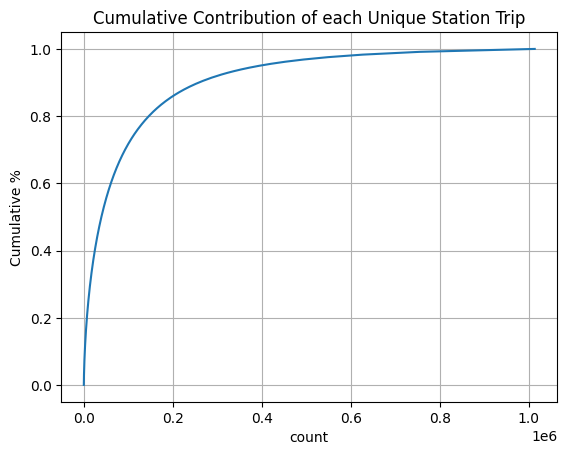

In [13]:
# ploting cumulative contribution
plt.plot(cumsum_df["cumulative_percent"].values)
plt.xlabel("count")
plt.ylabel("Cumulative %")
plt.title("Cumulative Contribution of each Unique Station Trip")
plt.grid(True)
plt.show()

In [14]:
# threshold
threshold = 0.80

topx_df = cumsum_df[cumsum_df["cumulative_percent"] <= threshold]

In [15]:
total_rows = len(df)

kept_rows = len(topx_df)

removed_rows = total_rows - kept_rows

percent_rows_kept = (kept_rows / total_rows) * 100


#### scratch work

In [17]:
# each station can have many different coordinate values
(pd.concat([ 
    filtered_data[["start_station_name", "start_lat", "start_lng"]].rename(columns = lambda x: x.replace("start_", "")),
    filtered_data[["end_station_name", "end_lat", "end_lng"]].rename(columns = lambda x: x.replace("end_", ""))
    ], ignore_index = True) # stack both start and end stations to get all unique
 .drop_duplicates()
 .groupby("station_name")[["lat", "lng"]].nunique()
)

,lat,lng
station_name,,
1 Ave & E 110 St,1871,2195
1 Ave & E 16 St,3072,2742
1 Ave & E 18 St,3108,2981
1 Ave & E 30 St,2050,1838
1 Ave & E 39 St,2645,2850
...,...,...
Wyckoff St & 3 Ave,86,87
Wyckoff St & Nevins St,749,881
Wythe Ave & Metropolitan Ave,2758,3200


In [18]:
# the difference between coordinate values within a given station is relatively small therefore we can take the average coords per station to get a singular value per station
(pd.concat([ 
    filtered_data[["start_station_name", "start_lat", "start_lng"]].rename(columns = lambda x: x.replace("start_", "")),
    filtered_data[["end_station_name", "end_lat", "end_lng"]].rename(columns = lambda x: x.replace("end_", ""))
    ], ignore_index = True) # stack both start and end stations to get all unique
 .drop_duplicates()
 .groupby(["station_name"])
 .agg({
     "lat": "std",
     "lng": "std"
 })
 .rename(columns = {"lat": "lat_std", "lng": "lng_std"})
 .reset_index()
 .sort_values(by = ["lat_std", "lng_std"], ascending = False)
)

,station_name,lat_std,lng_std
44,2 Ave & 39 St,0.019796,0.007619
287,6 Ave & 60 St,0.006854,0.001319
190,41 St & 3 Ave,0.006487,0.000065
1277,Morgan WH station,0.005860,0.006515
541,Cabrini Blvd & W 177 St,0.005758,0.000589
...,...,...,...
1600,Vernon Blvd & 30 Rd,NaN,NaN
1683,W 34 St &\tHudson Blvd E,NaN,NaN
1763,Warren St,NaN,NaN
1821,Willow Ave & 12 St,NaN,NaN


In [19]:
data["start_lat"].max()

40.883978248

In [20]:
data["start_lat"].min()

40.627368927

In [21]:
data.query("start_station_name.isna() | end_station_name.isna()")

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source,avgTempCelsius
170030,74EFAD3CDF3FCAD0,electric_bike,2022-01-12 05:34:03.133,2022-01-13 06:33:57.473,6 Ave & W 34 St,6364.10,None,NaN,40.749640,-73.988050,NaN,NaN,member,202201-citibike-tripdata_1,-1.9
170031,C7D7571348DC1998,electric_bike,2022-01-18 22:47:32.232,2022-01-19 23:47:11.390,2 Ave & E 96 St,7338.02,None,NaN,40.783964,-73.947167,NaN,NaN,member,202201-citibike-tripdata_1,1.8
170033,71BFE3EF048771B0,electric_bike,2022-01-02 09:21:14.492,2022-01-03 10:21:05.927,2 Ave & E 96 St,7338.02,None,NaN,40.783964,-73.947167,NaN,NaN,member,202201-citibike-tripdata_1,11.4
170036,1666143231C2DD1F,classic_bike,2022-01-02 15:08:02.631,2022-01-03 16:07:46.301,Riverside Dr & W 91 St,7524.16,None,NaN,40.793135,-73.977004,NaN,NaN,member,202201-citibike-tripdata_1,11.4
170039,17EECF976DB9A86F,electric_bike,2022-01-18 17:23:46.723,2022-01-19 18:23:37.597,Riverside Dr & W 91 St,7524.16,None,NaN,40.793135,-73.977004,NaN,NaN,member,202201-citibike-tripdata_1,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28506299,6AA5E821F9D1106C,classic_bike,2022-12-30 16:51:07.081,2022-12-31 17:50:59.112,E 25 St & 2 Ave,6046.02,None,NaN,40.739126,-73.979738,NaN,NaN,member,202212-citibike-tripdata_1,9.3
28506310,2E60991FC68E3871,electric_bike,2022-12-11 11:49:59.673,2022-12-11 11:55:00.155,Greene St & Prince St,5602.06,None,NaN,40.725206,-73.999114,40.74,-74.01,member,202212-citibike-tripdata_1,3.4
28506320,0E76C144E98B275B,electric_bike,2022-12-12 14:16:45.070,2022-12-12 15:24:43.846,W 104 St & Amsterdam Ave,7610.13,None,NaN,40.799012,-73.966460,40.81,-73.96,member,202212-citibike-tripdata_1,1.6
28506331,5723A292E7B6FF6B,electric_bike,2022-12-20 14:49:23.873,2022-12-20 17:45:37.865,Madison St & Montgomery St,5262.09,None,NaN,40.713208,-73.984699,40.71,-73.99,member,202212-citibike-tripdata_1,1.9


In [37]:
data.query("end_station_name == 'W 46 St & 11 Ave'").sort_values(by = "start_station_name")

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source,avgTempCelsius
6909503,91EB8A170A17BDCD,electric_bike,2022-05-26 16:02:37.062,2022-05-26 16:34:50.272,1 Ave & E 110 St,7522.02,W 46 St & 11 Ave,6795.01,40.792327,-73.938300,40.763414,-73.996674,member,202205-citibike-tripdata_1,16.4
4295,AEDD5AD571B5C9C6,classic_bike,2022-01-24 12:43:55.904,2022-01-24 13:36:39.368,1 Ave & E 110 St,7522.02,W 46 St & 11 Ave,6795.01,40.792327,-73.938300,40.763414,-73.996674,casual,202201-citibike-tripdata_1,-0.2
1200683,0833775EFCA2D4BE,electric_bike,2022-02-19 21:29:37.119,2022-02-19 21:49:26.363,1 Ave & E 16 St,5779.08,W 46 St & 11 Ave,6795.01,40.732219,-73.981656,40.763414,-73.996674,member,202202-citibike-tripdata_1,0.1
16151070,274DEBB5F892B53E,classic_bike,2022-08-01 23:17:03.980,2022-08-01 23:46:01.970,1 Ave & E 16 St,5779.08,W 46 St & 11 Ave,6795.01,40.732219,-73.981656,40.763414,-73.996674,casual,202208-citibike-tripdata_1,23.1
22229231,F613BB329FDC7F37,classic_bike,2022-09-30 19:48:03.347,2022-09-30 20:17:41.707,1 Ave & E 16 St,5779.08,W 46 St & 11 Ave,6795.01,40.732219,-73.981656,40.763414,-73.996674,member,202209-citibike-tripdata_3,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28666342,2D0D070DEFDED8B8,classic_bike,2022-12-29 11:46:01.778,2022-12-29 13:23:58.802,Wythe Ave & Metropolitan Ave,5348.02,W 46 St & 11 Ave,6795.01,40.716887,-73.963198,40.763414,-73.996674,casual,202212-citibike-tripdata_1,6.4
28666343,3BC4486AE18101CB,classic_bike,2022-12-29 11:45:28.702,2022-12-29 13:23:45.144,Wythe Ave & Metropolitan Ave,5348.02,W 46 St & 11 Ave,6795.01,40.716887,-73.963198,40.763414,-73.996674,casual,202212-citibike-tripdata_1,6.4
15198922,156D7DCACA850F33,classic_bike,2022-07-10 19:08:49.023,2022-07-10 20:27:38.465,Wythe Ave & Metropolitan Ave,5348.02,W 46 St & 11 Ave,6795.01,40.716887,-73.963198,40.763414,-73.996674,member,202207-citibike-tripdata_3,23.4
15199596,9566AF97611D6572,classic_bike,2022-07-01 11:51:28.080,2022-07-01 12:25:12.005,Wythe Ave & Metropolitan Ave,5348.02,W 46 St & 11 Ave,6795.01,40.716887,-73.963198,40.763414,-73.996674,member,202207-citibike-tripdata_3,28.1


## kepler.gl map

In [39]:
# initialize kepler.gl map
m = KeplerGl(height = 700, data = {"data_1": topx_df})
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':                        start_station_name                   end_station_name  \
0    …

### Load Map

In [71]:
with open('config.json') as config_file:
    config = json.load(config_file)

CitiBike_map = KeplerGl(config = config)
CitiBike_map.add_data(data = df, name = "data_1")
CitiBike_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['data_1'], 'id': 'ajcl7nzb9'…

In [73]:
config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data_1'],
     'id': 'ajcl7nzb9',
     'name': ['count'],
     'type': 'range',
     'value': [805, 999],
     'plotType': 'histogram',
     'animationWindow': 'free',
     'yAxis': None,
     'view': 'side',
     'speed': 1,
     'enabled': True}],
   'layers': [{'id': 'b9ukvym',
     'type': 'point',
     'config': {'dataId': 'data_1',
      'label': 'start',
      'color': [255, 245, 196],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'start_lat', 'lng': 'start_lng'},
      'isVisible': True,
      'visConfig': {'radius': 5,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       '

### Config & Save Map

In [41]:
config = m.config
config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data_1'],
     'id': 'h50tuw49f',
     'name': ['count'],
     'type': 'range',
     'value': [694, 999],
     'plotType': 'histogram',
     'animationWindow': 'free',
     'yAxis': None,
     'view': 'side',
     'speed': 1,
     'enabled': True}],
   'layers': [{'id': 'nr0gcl',
     'type': 'point',
     'config': {'dataId': 'data_1',
      'label': 'start',
      'color': [255, 223, 153],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'start_lat', 'lng': 'start_lng'},
      'isVisible': True,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       's

In [43]:
with open("config.json", "w") as outfile:
    json.dump(config, outfile)

In [45]:
m.save_to_html(file_name = "NYC CitiBike 2022.html", read_only = False, config = config)

Map saved to NYC CitiBike 2022.html!


### scratch work

In [26]:
df.sort_values(by = "count", ascending = False).head(50)

,start_station_name,end_station_name,count,start_lat,start_lng,end_lat,end_lng
129601,Central Park S & 6 Ave,Central Park S & 6 Ave,12041,40.765965,-73.976420,40.765965,-73.976420
58520,7 Ave & Central Park South,7 Ave & Central Park South,8541,40.766622,-73.979305,40.766622,-73.979305
745689,Roosevelt Island Tramway,Roosevelt Island Tramway,8213,40.757230,-73.953537,40.757230,-73.953537
278631,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7287,40.764334,-73.973853,40.764334,-73.973853
361582,Soissons Landing,Soissons Landing,7275,40.692462,-74.014815,40.692462,-74.014815
66137,W 21 St & 6 Ave,9 Ave & W 22 St,6345,40.741735,-73.994049,40.745533,-74.001964
49758,5 Ave & E 72 St,5 Ave & E 72 St,6037,40.772737,-73.966949,40.772737,-73.966949
6618,1 Ave & E 62 St,1 Ave & E 68 St,5826,40.761263,-73.960816,40.765033,-73.958120
819949,Yankee Ferry Terminal,Yankee Ferry Terminal,5759,40.687112,-74.016628,40.687112,-74.016628
118268,Broadway & W 58 St,Broadway & W 58 St,5509,40.766803,-73.981861,40.766803,-73.981861


In [27]:
# number of routes and number of trips where the start and end stations are the same in the Top 50 routes
(df \
 .assign(same = df["start_station_name"] == df["end_station_name"])
 .sort_values(by = "count", ascending = False)
 .head(50)
 .groupby("same")["count"]
 .agg(["sum", "count"])
)

,sum,count
same,,
False,130549,32
True,106985,18
